### Code Hist.

   - CODE : Crawling - 날씨 정보 조회 (KMA)  
    
   - DESC : 대한민국 기상청 황사관측(PM10) 데이터 Crawling  

  - DATE  
    &ensp; 2023-06-05 Created  
    &ensp; 2023-11-27 Code 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 기존 Template에 맞게 통일  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) 공통코드 사용 (.ipynb)   
    &ensp; 2024-07-17 Code 분리 및 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) WS_DataScience로부터 Workspace 분리  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Code 간략화  
    
 - DATA  
    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    2) Daily (관측소/년도별 출력)  

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os, sys, warnings
os.path.dirname(os.path.abspath('./__file__'))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('./__file__'))))
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = '{:.10f}'.format

## Datetime
import time, datetime as dt
from datetime import datetime, date, timedelta

import glob, requests, json
from glob import glob

from scipy import stats

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## 시각화
import seaborn as sns, matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

#endregion Basic_Import

In [2]:
## Import_Local
from Dev_Common import Data_Datetime as com_date, KMA_Weather_ASOS as com_KMA, KASI_Holiday as com_Holi, KMA_Weather_ASOS as com_ASOS

### 01-01-02. Config (Directory, Params)

In [3]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y, str_now_m, str_now_d = pd.datetime.now().year, pd.datetime.now().month, pd.datetime.now().day
str_now_hr, str_now_min = pd.datetime.now().hour, pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-07-18 13:12:51.297552
2024 / 7 / 18
13 : 12


In [4]:
# Define data root directory
str_dir_PM10 = "../data_KMA_PM10/" ## 황사관측 Directory
# print(os.listdir(str_dir_kmaPM10))

file_key = open('../str_key_KMA.txt', 'r') ## 개인 Key (외부 노출 금지)
str_key = file_key.readline()

In [5]:
## Weather_ASOS Parameter
## 기간 설정 (2010 - 2024)
year_Start, year_End = 2010, 2024
str_dt_start, str_dt_end = str(year_Start)+'-01-01', str(year_End)+'-12-31'

# str_Interval = 'DAY' ## 일
str_Interval = 'HR' ## 시간
if str_Interval == 'HR': list_page = list(range(0, 13))
elif str_Interval == 'DAY': list_page = list(range(0, 4))

#### 01-01-02-02. Config (관측소 정보)

In [6]:
## 관측소
## [● 가능] 
# Observatory = "108" ## [● 가능] 서울
Observatory = "119" ## [● 가능] 수원
# Observatory = "131" ## [● 가능] 청주
# Observatory = "99" ## [● 가능] 파주 
# Observatory = "143" ## [● 가능] 대구
# Observatory = "253" ## [● 가능] 김해시
# Observatory = "156" ## [● 가능] 광주
# Observatory = "257" ## [● 가능] 양산시
# Observatory = "159" ## [● 가능, H만] 부산

In [7]:
#region [X 불가] 
## 강남
# Observatory = "400" ## [X 불가] 강남 (2010-2023 데이터 없음)
# Observatory = "1100" ## [X 불가] 강남구청 (2010-2023 데이터 없음)
# Observatory = "1159" ## [X 불가] 강남 (2010-2023 데이터 없음)
## 세종
## 데이터가 존재하지 않아, 청주 데이터로 대체
# Observatory = "239" ## [X 불가] 세종 (2019-05-31 11:00 ~)
# Observatory = "494" ## [X 불가] 세종 고운 (2010-2023 데이터 없음)
# Observatory = "496" ## [X 불가] 세종 금남 (2010-2023 데이터 없음)
# Observatory = "611" ## [X 불가] 세종 연기/연서 (2010-2023 데이터 없음)
# Observatory = "629" ## [X 불가] 세종 전의 (2010-2023 데이터 없음)
# Observatory = "887" ## [X 불가] 세종시 (2010-2023 데이터 없음)
# Observatory = "4707" ## [X 불가] 세종시 (연서면)
## 고양
# Observatory = "540" ## [X 불가] 파주기상대 - 고양 (2010-2023 데이터 없음)
## 분당
# Observatory = "364" ## [X 불가] 분당구 (2010-2023 데이터 없음)
# Observatory = "572" ## [X 불가] 성남 (2010-2023 데이터 없음)
## 전남광주
# Observatory = "156" ## [X 불가] 광주 (2010-2023 데이터 없음)
## 용인
# Observatory = "549" ## [X 불가] 용인
## 경기광주 (성남 대체 목적)
# Observatory = "546" ## [X 불가] 경기광주
## 평택
# Observatory = "551" ## [X 불가] 평택 
## 화성
# Observatory = "571" ## [X 불가] 화성
#endregion [X 불가] 

In [8]:
#region [△ 미상] 
## 수원
# Observatory = "971" ## 수원(농)
# Observatory = "1727" ## 수원시(서둔동)
## 광교
# Observatory = "11452" ## 광교동
## 청주
# Observatory = "127" ## 청주기상대/충주
# Observatory = "135" ## 청주기상대/추풍령
# Observatory = "324" ## 청주
# Observatory = "325" ## 청주
# Observatory = "327" ## 청주
# Observatory = "399" ## 서청주
# Observatory = "600" ## 청주(금왕)
# Observatory = "601" ## 청주기상대/단양
# Observatory = "602" ## 청주기상대/진천
# Observatory = "603" ## 청주기상대/괴산
# Observatory = "604" ## 청주기상대/옥천
# Observatory = "605" ## 청주기상대/영동
# Observatory = "619" ## 청주기상대/영동
## 파주
# Observatory = "431" ## 파주기상대 - 신곡
# Observatory = "450" ## 파주기상대 - 주교
# Observatory = "481" ## 파주기상대 - 탄현
# Observatory = "482" ## 파주기상대 - 광탄
# Observatory = "483" ## 파주기상대 - 진동
# Observatory = "499" ## 파주기상대 - 중면
# Observatory = "503" ## 파주기상대 - 도라산
# Observatory = "506" ## 파주금촌
# Observatory = "532" ## 파주기상대 - 의정부
# Observatory = "567" ## 파주기상대 - 적성
# Observatory = "588" ## 파주기상대 - 양주
# Observatory = "692" ## 파주기상대 - 백학
# Observatory = "1403" ## 파주
# Observatory = "1888" ## 파주
# Observatory = "1905" ## 파주 비학산
# Observatory = "47099" ## 파주
## 고양
# Observatory = "540" ## 고양고봉
# Observatory = "589" ## 파주기상대 - 능곡
# Observatory = "1273" ## 고양
# Observatory = "1442" ## 고양
# Observatory = "1702" ## 고양시1(구산동)
# Observatory = "1724" ## 고양시2(덕양구)
# Observatory = "1970" ## 고양
## 판교
# Observatory = "1318" ## 판교동주민센터
# Observatory = "11535" ## 대왕판교로
# Observatory = "14251" ## 판교현암
## 분당
# Observatory = "1320" ## 성남시청
# Observatory = "1460" ## 성남대로
# Observatory = "2940" ## 성남탐방로
# Observatory = "4292" ## 성남신사
# Observatory = "4397" ## 성남보건지소
## 용인
# Observatory = "1575" ## 용인이동
# Observatory = "1576" ## 백암
# Observatory = "11716" ## 용인시(처인구)
# Observatory = "11902" ## 용인 응봉
## 화성
# Observatory = "1515" ## 운평
# Observatory = "1544" ## 전곡항
# Observatory = "1571" ## 화성
# Observatory = "11723" ## 화성시(봉담읍)
# Observatory = "13173" ## 화성
# Observatory = "14310" ## 화성산정
## 오산 (용인과 평택 대체 가능)
# Observatory = "550" ## 오산
## 평택
# Observatory = "11543" ## 평택항
# Observatory = "11721" ## 평택시(오성면)
# Observatory = "14954" ## 서해대교(평택측)
## 대구
# Observatory = "1176" ## 대구(기)
# Observatory = "1828" ## 달성
# Observatory = "1845" ## 대구북구
# Observatory = "1846" ## 대구서구
# Observatory = "1860" ## 신암
# Observatory = "17734" ## 대구시(북구)
# Observatory = "17970" ## 대구
# Observatory = "147143" ## 대구
## 김해
# Observatory = "1673" ## 진영
# Observatory = "1925" ## 생림
# Observatory = "18703" ## 김해시(전하동)
# Observatory = "18975" ## 김해

## 양산
# Observatory = "1905" ## 양산상북

## 광주
# Observatory = "1316" ## 무등산
# Observatory = "1546" ## 경기광주
# Observatory = "1689" ## 광주남구
# Observatory = "1708" ## 광산
# Observatory = "1722" ## 조선대
# Observatory = "1783" ## 과기원
# Observatory = "1788" ## 풍암
# Observatory = "147156" ## 광주
# Observatory = "147158" ## 광주

## 부산
# Observatory = "296" ## 북부산

#endregion [△ 미상] 

## 01-02. Data Load (df_raw)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


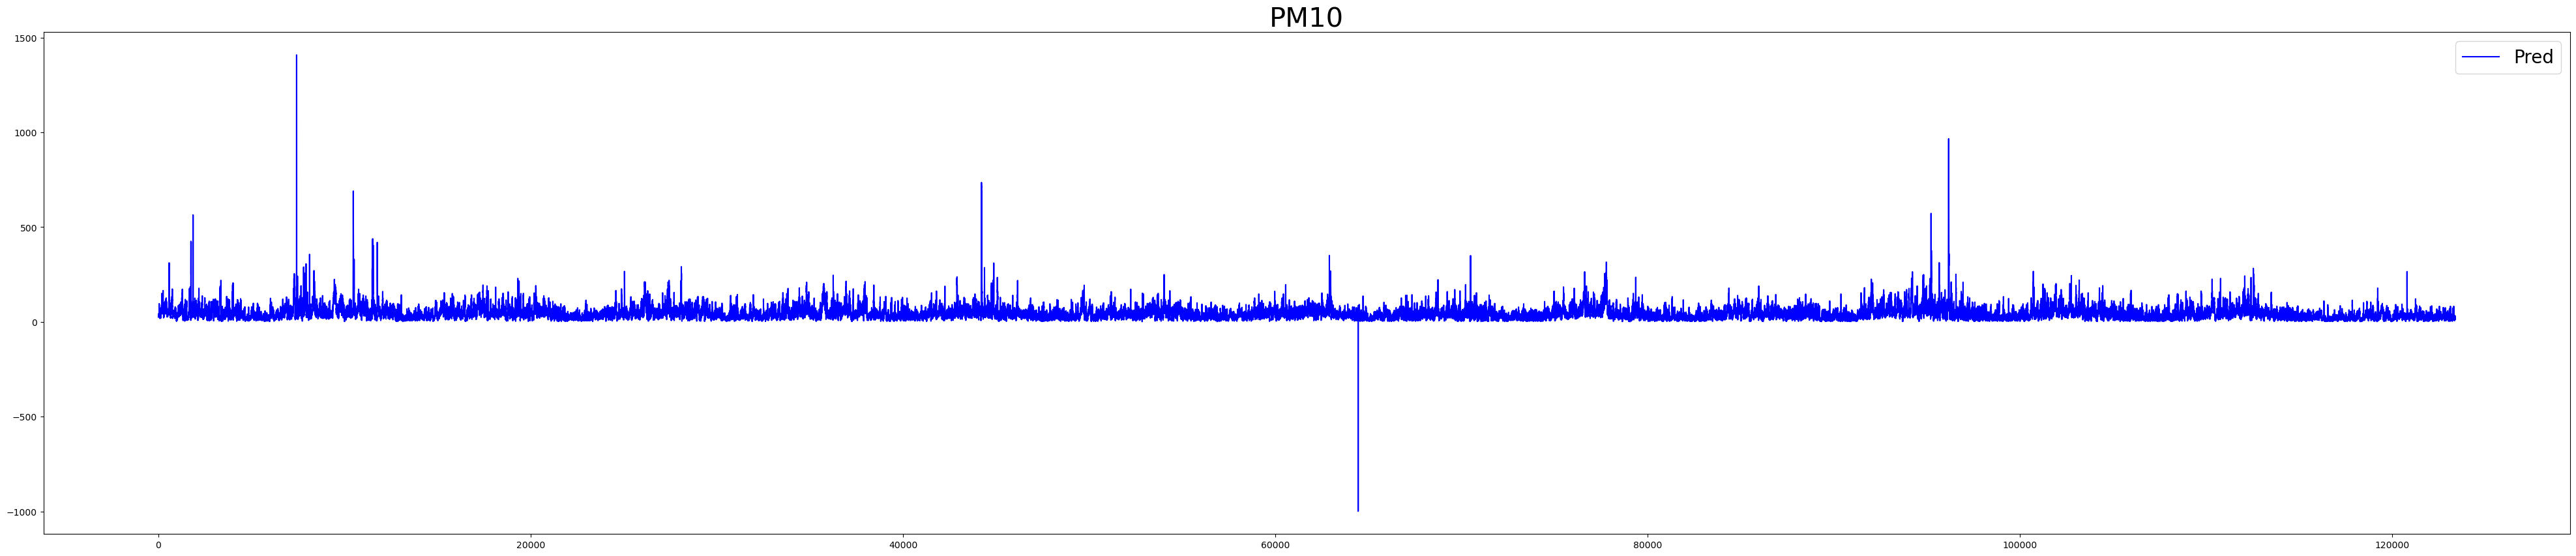

,METER_DATE,PM10
0,2010-01-01 00:00:00,32
1,2010-01-01 01:00:00,24
2,2010-01-01 02:00:00,30
3,2010-01-01 03:00:00,30
4,2010-01-01 04:00:00,32
...,...,...
123367,2024-07-16 19:00:00,19
123368,2024-07-16 20:00:00,25
123369,2024-07-16 21:00:00,24
123370,2024-07-16 22:00:00,18


In [11]:
df_PM10_total = pd.DataFrame()
for year in range(year_Start, year_End + 1):
    print(year)
    df_PM10 = pd.read_csv(str_dir_PM10 + 'KMA_PM10_' + str(year) + '.csv', encoding='cp949')
    df_PM10 = df_PM10[df_PM10['지점'] == int(Observatory)]
    df_PM10_total = pd.concat([df_PM10_total, pd.DataFrame(df_PM10)])
df_PM10_total = df_PM10_total.reset_index().rename(columns = {'일시' : 'METER_DATE','1시간평균 미세먼지농도(㎍/㎥)' : 'PM10'})[['METER_DATE', 'PM10']]
df_PM10_total['METER_DATE'] = pd.to_datetime(df_PM10_total['METER_DATE'])

## Raw 시각화
plt.figure(figsize=(50,10))
str_title = 'PM10'
plt.plot(df_PM10_total['PM10'],color='blue',label='Pred')
plt.title(str_title, fontsize = 30)
plt.legend(fontsize = 20)
plt.show()

df_PM10_total

## Data Cleansing

In [14]:
## 음수 제거
for i in range(0, len(df_PM10_total['PM10'])):
    if(df_PM10_total['PM10'][i] < 0):
        df_PM10_total['PM10'][i] = np.NaN

In [16]:
## 단순선형보간
dt_period = pd.to_datetime(df_PM10_total['METER_DATE'])
df_dt_hr = com_date.create_df_dt(pd.DataFrame(), 'METER_DATE'
                                 , dt_period.min(), dt_period.max(), '1H')

Df_PM10 = pd.merge(df_dt_hr, df_PM10_total, how = 'left', on = ['METER_DATE'])
Df_PM10['PM10'] = Df_PM10['PM10'].interpolate()

print(Df_PM10.columns, ' /// ', Df_PM10.shape)
print(Df_PM10.info())
Df_PM10

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'PM10'],
      dtype='object')  ///  (127464, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127464 entries, 0 to 127463
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   METER_DATE            127464 non-null  datetime64[ns]
 1   day_of_the_week       127464 non-null  object        
 2   YEAR                  127464 non-null  int64         
 3   MONTH                 127464 non-null  int64         
 4   DAY                   127464 non-null  int64         
 5   HOUR                  127464 non-null  int64         
 6   MINUTE                127464 non-null  int64         
 7   code_day_of_the_week  127464 non-null  int64         
 8   PM10                  127464 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 9.7+ M

,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,PM10
0,2010-01-01 00:00:00,Friday,2010,1,1,0,0,4,32.0000000000
1,2010-01-01 01:00:00,Friday,2010,1,1,1,0,4,24.0000000000
2,2010-01-01 02:00:00,Friday,2010,1,1,2,0,4,30.0000000000
3,2010-01-01 03:00:00,Friday,2010,1,1,3,0,4,30.0000000000
4,2010-01-01 04:00:00,Friday,2010,1,1,4,0,4,32.0000000000
...,...,...,...,...,...,...,...,...,...
127459,2024-07-16 19:00:00,Tuesday,2024,7,16,19,0,1,19.0000000000
127460,2024-07-16 20:00:00,Tuesday,2024,7,16,20,0,1,25.0000000000
127461,2024-07-16 21:00:00,Tuesday,2024,7,16,21,0,1,24.0000000000
127462,2024-07-16 22:00:00,Tuesday,2024,7,16,22,0,1,18.0000000000


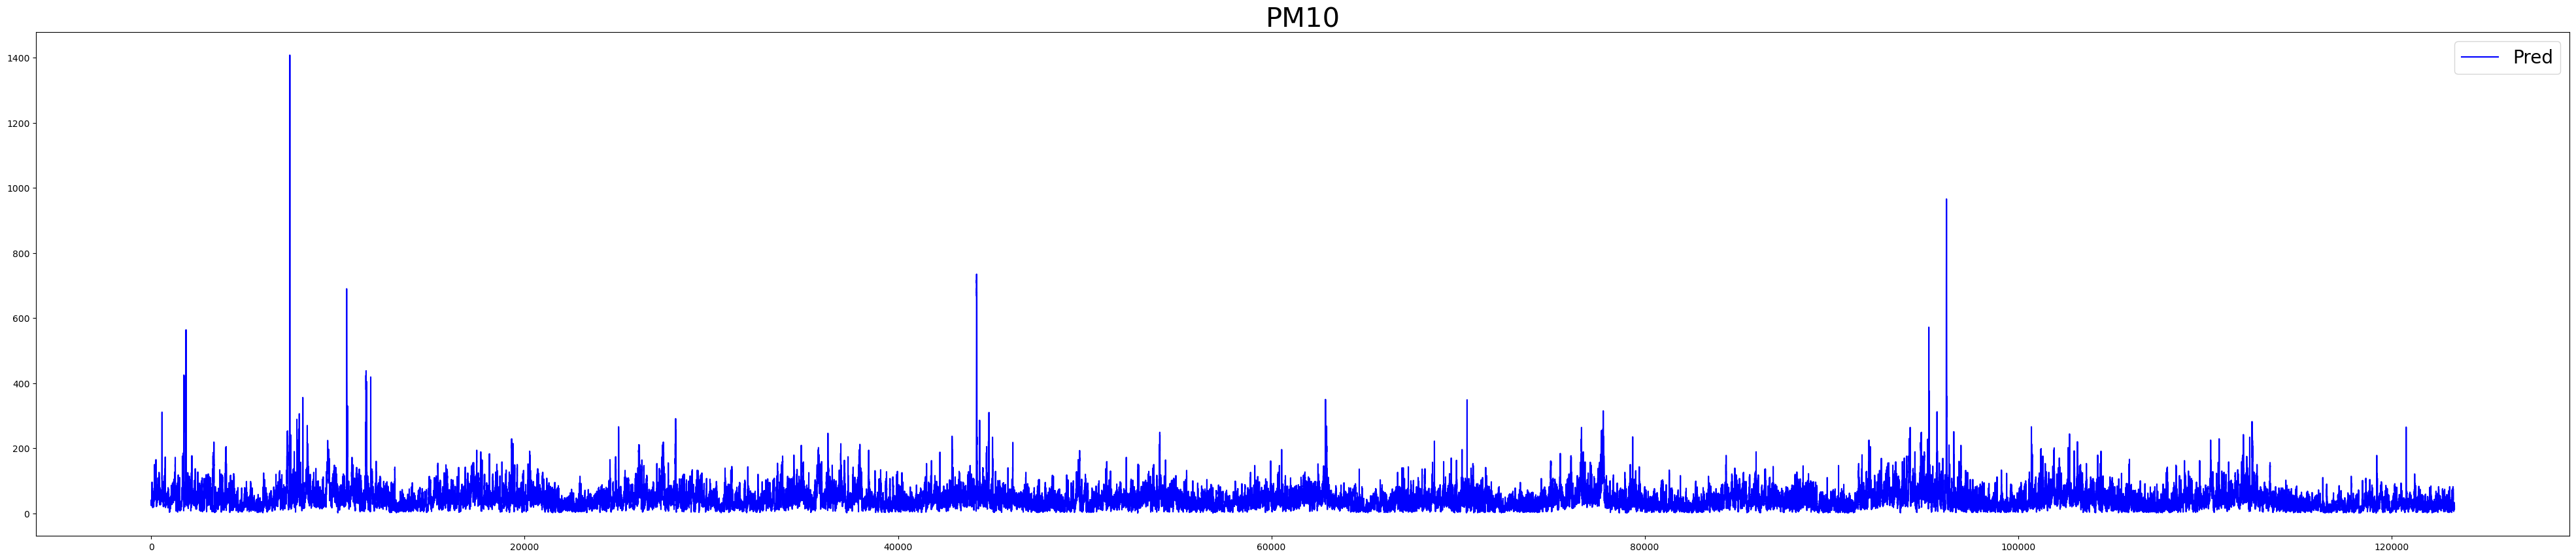

In [17]:
## Cleansed 시각화
plt.figure(figsize=(50,10))
str_title = 'PM10'
plt.plot(df_PM10_total['PM10'],color='blue',label='Pred')
plt.title(str_title, fontsize = 30)
plt.legend(fontsize = 20)
plt.show()

In [18]:
# Data_ASOS.columns
Df_PM10.to_csv(str_dir_PM10 + 'KMA_PM10_' + str(Observatory) + "_" + str(year_Start) + '-' + str(year_End) + '_Cleansed_HR.csv')